In [1]:
from google.colab import drive
drive.mount('/content/drive')
isCdir = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import re #regex libraray
import string #to remove punctuation
from collections import Counter #to make knn more generic
from scipy.spatial.distance import cdist
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 


#Part 2
from sklearn.neighbors import KNeighborsClassifier

#part 3
from gensim.models import KeyedVectors


if not isCdir:
  os.chdir(os.getcwd()+"/drive/My Drive/Machine Learning/A1")
  isCdir = True


In [3]:
#Used in part 3
word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
def loadData(fileName):
    '''function to load data into a dataframe'''
    
    df = pd.read_csv(fileName)
    return df

In [5]:
def loadStopWords(filename):
    '''function to remove stopwords'''
    
    stopWords = set()
    with open(filename,'r') as file:
        for word in file:
            word = word.strip()
            stopWords.add(word)
    return stopWords
           
        
    

In [6]:
stopWords = loadStopWords("stop_words.txt") #loading stopwrods

In [7]:
#loading the training data and seeing the first five enteries
trainSet = loadData("train.csv")
trainSet.head()

,Sentiment,Tweet
0,neutral,"@united 877 from amsterdam to ewr, 02.27.2015,..."
1,negative,@united IT-problems with the link? #3thparty
2,positive,@united -today the staff @ MSP took customer s...
3,negative,@AmericanAir but have been yet to receive assi...
4,negative,@SouthwestAir you won't let me change my rese...


In [8]:
#loading the testing data and seeing the first five enteries
testSet = loadData("test.csv")
# testSet = testSet.sample(n=1000)
testSet.head()

,Sentiment,Tweet
0,neutral,@VirginAmerica to jump into the Dallas-Austin ...
1,positive,"@AmericanAir Chicago seen from seat 6A, AA 162..."
2,negative,@united you need a bag bouncer. Get it together
3,negative,"@JetBlue Hey Jetblue, you stranded an entire p..."
4,negative,@USAirways Big fail on not having curbside bag...


In [9]:
stopWords = sorted(list(stopWords)) #converting the stopwords to a list and sorting them

In [10]:
def preprocessing(text):
    '''fnction to remove stop words,urls,usernames,punctuation'''
    
    #lowercasing the text 
    text = text.lower()
    #removing url using it from nlp course 
    text = re.sub(r' https?://t\.co/[A-Za-z0-9]{10}'," ",text)
    # print(text)
    
    #removing the @username
    text = re.sub(r'@[0-9A-Za-z]*'," ",text)
    # print(text)
    
    #removing hashtags
    text = re.sub(r'#[0-9A-Aa-z]*'," ",text)
    # print(text)
    


    #removing everything except alphabets
    text = re.sub("[^a-zA-Z]", " ",text) 
    # print(text)

    
    #removing sopwords
    for word in stopWords:
        #removing stopwords using regex
        regex = r'\b'+word+r'\b'
        text = re.sub(regex," ",text)
    
    
    #removing punctuations
    for word in string.punctuation:
        text = text.replace(word," ")
    text = text.strip()
    # print(text)
    
    return text
    
    
    
    

In [11]:
trainSet['Tweet'] = trainSet['Tweet'].apply(preprocessing) #preprocessing the training data
testSet['Tweet'] = testSet['Tweet'].apply(preprocessing) #preprocessing the testing data5

In [12]:
def lookEmpty():
  trainEmpty = []
  testEmpty = []

  for i,data in enumerate(trainSet['Tweet']):
    if len(data)==0:
      trainEmpty.append(i)
  for j,data in enumerate(testSet['Tweet']):

    if len(data)==0:
      print(testSet['Tweet'][j])
      print(data)
      testEmpty.append(j)
  return trainEmpty,testEmpty
a,b = lookEmpty()
a,b

([280, 4074, 4765, 5569, 7540, 8868, 9045], [500, 576, 1072, 2807])

In [13]:
print("In Training data")
for i in a:
  print(trainSet['Tweet'][i])
  # print(preprocessing(trainSet['Tweet'][i]))
print("In Testing data")
for i in b:
  print(testSet['Tweet'][i])
  # print(preprocessing(testSet['Tweet'][i])+"end")
print(len(trainSet))
print(len(testSet))

In Training data







In Testing data




11680
2921


In [14]:
trainSet.drop(index=a,labels=None, axis=0, inplace=True,columns=None, level=None, errors='raise')
testSet.drop(index=b,labels=None, axis=0, inplace=True,columns=None, level=None, errors='raise')

# trainSet.index


In [15]:
testSet.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920],
           dtype='int64', length=2917)

In [16]:
trainSet = trainSet.reset_index(drop=True)
testSet = testSet.reset_index(drop=True)

In [17]:
trainSet.index

RangeIndex(start=0, stop=11673, step=1)

In [18]:
preprocessing("@AmericanAir flight delayed 3 times today due to flight officer. 4333 from pit to ord. 5 hour delay to date. #bademployeeproblem?")

'flight delayed   times today due   flight officer         pit   ord    hour delay   date'

In [19]:
trainSet['Tweet'].head() #seeing the head of the processed training data 

0                                      amsterdam   ewr
1                                    problems     link
2    today   staff   msp took customer service     ...
3    yet   receive assistance   one     agents   se...
4    let   change   reservation online           wa...
Name: Tweet, dtype: object

In [20]:
def createDictionary(data):
    '''function to create dictionary
    data-> training data
    returns a dictionary with word count of words whos lenght>2
        as words of length 2 are usually stopwords
    
    '''
    psudodict = {}
   
    for tweet in data:
        tweet = tweet.split()
        for words in tweet:
            if words in psudodict.keys():
                psudodict[words]+=1
            elif len(words)>2:
                psudodict[words]=1
                
            
     
    return psudodict

In [21]:
dictionary = createDictionary(trainSet['Tweet']) #obtaining disctionary only on the training data


#creating an empty dictionary to create word vectors
useDictionary = {k: 0 for v, k in enumerate(dictionary)}



In [22]:
def creatBagOfWords(data):
    '''function to create bag of words representation
        of training and testing data. 
        dictionary is created on training data 
        so words not in training data are ignored by the else block
        
        returns->BOW representation of the data '''
    countList = []
    for tweet in data:
        tweet = tweet.split()
        pseudoDict = useDictionary.copy()
        for word in tweet:
            if word in useDictionary.keys():
                pseudoDict[word]+=1
            else:
                #words not in training set are ignored automatically 
                continue
        countList.append((np.array(list(pseudoDict.values()))))
    return np.array(countList)
    
            
            
    
    

In [23]:
#obtaining training and testing BOW representations and creating class labels->integer dictionary

trainBOW = creatBagOfWords(trainSet['Tweet'])
testBOW = creatBagOfWords(testSet['Tweet'])
trainBOWArray = trainBOW
testBOWArray = testBOW
labelDict  ={'positive':1,'neutral':0,'negative':2}

In [24]:
def convertLabels(data):
    '''function to convert class labels(pos,neg,neut) into intergers'''
    labelList = []
    for label in data:
        labelList.append(labelDict[label])
    return labelList
        

In [25]:
trainLabel = convertLabels(trainSet['Sentiment'])
testLabel = convertLabels(testSet['Sentiment'])
trainSet['label'] = trainLabel
testSet['label'] = testLabel

In [26]:
testSet

,Sentiment,Tweet,label
0,neutral,jump dallas austin market news,0
1,positive,chicago seen seat aa far great...,1
2,negative,need bag bouncer get together,2
3,negative,hey jetblue stranded entire plane sup...,2
4,negative,big fail curbside baggage pittsburgh ...,2
...,...,...,...
2912,negative,yet next terminal customer service ...,2
2913,neutral,hope pilot good day,0
2914,negative,hold hours answer,2
2915,negative,come already delayed hrs flight ...,2


# Part 1

In [27]:
class KNN(object):
    def __init__(self,trainBOWArray,trainLabel,testBOWArray,testLabel,labelDict,k,isDone=True):
        
        self.XTrain = trainBOWArray
        self.YTrain = trainLabel
        self.XTest = testBOWArray
        self.YTest = testLabel
        self.Mapper = labelDict
        self.k = k
        self.labels = []
        self.isDone = isDone
        self.result = []
        self.classificationDict = {}
    def computeDistance(self,array):
        '''function to calulate eucleidean distance
        of array with training data'''
        distanceVec = []
        for vector in self.XTrain:
#             print(np.shape(vector))
#             print(np.shape(array))
            
           
            dist = np.linalg.norm(vector-array)
            distanceVec.append(dist)
        return distanceVec
    def doSorting(self,distanceVec,k):
        '''function to get the sorted indexes up to k enteries'''
        return np.argsort(distanceVec)[:k]
    
    def checkTie(self,labels):
        '''function to check ties 
                returns true,-1 if ties is found
                false,classLabel if no
                tie is fond
        '''
        counter = Counter()
        for _,v in self.Mapper.items():
    
            counter[v] = 0
        
        for label in labels:
            counter[label]+=1
            
        values = counter.most_common(2)
        
        if values[0][1] == values[1][1]:
            return True,-1
        else:
            return False,values[0][0]
        
    
    def computeDistanceTest(self):
        
        self.labels = []
        
       
        #if isDone is false computation will occure from scratch else already computed distances will be used
        if not self.isDone:
            
            #calculating distance between testing data and training data

            result = cdist(self.XTest,self.XTrain,metric="euclidean")
            #sorting indexes
            result = np.argsort(result)
            
            #dumping the computed distances

            if self.XTest[0].shape[0]==300:
              with open('embeedings.pickle', 'wb') as handle:
                pickle.dump(result, handle)
            else:
              with open('filename.pickle', 'wb') as handle:
                pickle.dump(result, handle)

            
            
            #setting the variale true so that future computations do not have to calculate it again
            self.isDone=True
        else:
            
            #loading the pre-computed distances


            if self.XTest[0].shape[0]==300:
              with open('embeedings.pickle', 'rb') as handle:
                  result = pickle.load(handle)
            else:
              with open('filename.pickle', 'rb') as handle:
                result = pickle.load(handle)
        
        #evaluating results and predicting its labels
        for data in result:
            isTie = True 
            k = self.k 
            label = -1
            
            #if a tie occured on k-nn it backs off to (k-1)nn until there is no tie
            while isTie:
             
                labelsPredicted = trainSet['label'][data[:k]]
                # print(labelsPredicted)
                isTie,label = self.checkTie(labelsPredicted)
                if isTie:
                    k=k-1

            self.labels.append(label)
        
        

        self.labels = np.array(self.labels)
#         acc = 0
#         for val1,val2 in zip(self.labels,testLabel):
#             if val1==val2==2:
#                 acc+=1
        
        #printing k,accuracy and the general 3x3 confusion matrix
        print("For k=",self.k)
        print("Accuracy:",self.computeAccuracy(self.labels))
        self.createConfusionGeneral()

    
            
        return self.labels

    
    def computeAccuracy(self,labels):
        '''function to compute accuracy
            formulae: 1/n*(ytrue==ypred)'''
        
        b = np.array(self.YTest[:])
#         print("Count=",(b==labels).sum())
        return np.mean(b==labels)      
    
    def changeK(self,k):
        '''function to do computations with a changed k'''
        self.k = k
        self.computeDistanceTest()
        
    
    def createConfusionGeneral(self):
        '''function to create a confusion matrix 3x3'''
        
        
        def calculate0():
            '''function to calculate 0th class row'''
            a,b,c = 0,0,0
            for x,y in zip(self.labels,testLabel):
                
                if x==0:
                    if y==0:
                        a+=1
                    elif y==1:
                        b+=1
                    elif y==2:
                        c+=1
            return a,b,c
        def calculate1():
            '''function to calculate 1st class row in the confusion matrix'''
            a,b,c = 0,0,0
            for x,y in zip(self.labels,testLabel):
                if x==1:
                    if y==1:
                        b+=1
                    elif y==0:
                        a+=1
                    elif y==2:
                        c+=1
            return a,b,c
                
            
                    
        def calculate2():
            '''function to calculate the 2nd class row in the confusion matrix'''
            a,b,c = 0,0,0
            for x,y in zip(self.labels,testLabel):
                if x==2:
                    if y==0:
                        a+=1
                    elif y==1:
                        b+=1
                    elif y==2:
                        c+=1
            return a,b,c

        calc1 = calculate0()
#         print(calc1)
        calc2 = calculate1()
#         print(calc2)
        calc3 = calculate2()
#         print(calc3)
        
        confusionMatrix = np.array([np.array(calc1),np.array(calc2),np.array(calc3)])
        print("Confusion Matrix:",confusionMatrix)
                    
                
                
        
    def count(self,i):
        '''function to convert the 3x3 confusion matrix into 1 vs other 2x2 confusion matrix'''
        
        tp=0
        tn = 0
        fp = 0
        fn = 0
        
       
        count = 0
        
        for x,y in zip(self.labels,testLabel):
            
            if x==i and y==i:
                tp+=1
            elif x!=i and y!=i:
                tn+=1
            elif x==i and y!=i:
                fp+=1
            elif x!=i and y==i:
                fn+=1
                
            if x==i and y!=i:
                fp+=1
            elif x!=i and y==i:
                fn+=1
        return np.array([[tp,fp/2],[fn/2,tn]])
    
    def macroAvg(self):
        
        '''function to calculate macrov Avg 
            precision,recall and f1-score,prininting 
            confusion matrix and plots as well
        '''
        
       
        
        alist = np.array(self.count(0))
        print("Conusion matrix with respect to 0 class")
        print(alist)
        
        p1 = self.macroP(alist)
        r1 = self.macroR(alist)
        f11 = self.macroF1(p1,r1)
        
#         print("Macro Precision=",p1)
#         print("Macro Recall=",r1)
#         print("Macro F1 Score=",f11)
        
        print("Conusion matrix with respect to 1 class")
        blist = np.array(self.count(1))
        print(blist)
        p2 = self.macroP(blist)
        r2 = self.macroR(blist)
        f12 = self.macroF1(p2,r2)
#         print("Macro Precision=",p2)
#         print("Macro Recall=",r2)
#         print("Macro F1 Score=",f12)
        
        print("Conusion matrix with respect to 2 class")
        clist = np.array(self.count(2))
        print(clist)
        p3 = self.macroP(clist)
        r3 = self.macroR(clist)
        f13 = self.macroF1(p3,r3)


        macroP = (p1+p2+p3)/3
        macroR = (r1+r2+r3)/3
        macroF1  =(f11+f12+f13)/3
        print("Macro Precision=",macroP)
        print("Macro Recall=",macroR)
        print("Macro F1 Score=",macroF1)
        print()
        print()
        
        return macroP,macroR,macroF1
       
        

                
    def macroP(self,macroArray):
        '''functio to calculate macro average precision'''
    
        return macroArray[0][0]/(macroArray[0][0]+macroArray[0][1])
        
    def macroR(self,macroArray):
        '''function to calculate macro avg recall'''
        return macroArray[0][0]/(macroArray[0][0]+macroArray[1][0])
        
    def macroF1(self,p,r):
        '''function to calculate macro F1 score'''
        return 2*p*r/(p+r)
    
    def calculateAccuracyOverK(self):
        '''function to do knn over the asked array in the assignment'''
        k = [1,3,5,7,10] #as asked in the assignment 
        
        accuracy = []
        p = []
        r = []
        f1 = []
        
        for value in k:
            self.k = value
            result = self.computeDistanceTest()
            acc = self.computeAccuracy(result)
            accuracy.append(acc)
            
            pp,rr,ff =self.macroAvg()
            p.append(pp)
            r.append(rr)
            f1.append(ff)
        self.plot(accuracy,p,r,f1,k)
    def plot(self,accuracy,p,r,f1,k):
        '''function to plot the following:
            accuracy
            macroavg precision
            macroavg recall
            macro avg f1-score
        '''
        
        
        plt.plot(k, accuracy, label = "Accuracy") 
        plt.xlabel('k')
        
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
        
       
        plt.plot(k,p,label="Macro Precision")
        plt.ylabel("Precision")
        plt.xlabel('k')
        plt.legend()
        plt.show()
        
        
        plt.plot(k,r,label="Macro Recall")
        plt.ylabel("Recall")
        plt.xlabel('k')
        plt.legend()
        plt.show()
        
        
        plt.plot(k,f1,label="Macro F1")
        plt.ylabel("F1-Score")
        

        plt.xlabel('k')
        plt.legend()
        plt.show()
        
#         plt.ylabel('Perfomrance Measures') 
#         plt.legend() 
#         plt.show()

    def part2(self):
        '''function to perform knn using scikit-learn as asked in part2 of the assignment'''
        self.result = []
        
        precision = []
        recall = []
        f1score = []
        accuracy = []
        k = [1,3,5,7,10]
        for value in k:
            print("k=",value)
            neigh = KNeighborsClassifier(n_neighbors=value,n_jobs=-1)
            neigh.fit(self.XTrain, self.YTrain)

            self.result = neigh.predict(self.XTest)
            acc = accuracy_score(self.YTest,self.result)
            accuracy.append(acc)
            print("Accuracy is:",acc)
            print()
            print("Confusion Matrix=")
            print(confusion_matrix(self.YTest,self.result))

            print(classification_report(self.YTest,self.result))

            self.classificationDict = classification_report(self.YTest,self.result,output_dict=True)

            p = self.classificationDict["macro avg"]["precision"]
            r = self.classificationDict["macro avg"]["recall"]
            f1 = self.classificationDict["macro avg"]["f1-score"]

            precision.append(p)
            recall.append(r)
            f1score.append(f1)
            
            print()
            print()
        self.plot(accuracy,precision,recall,f1score,k)
        
        
        
        
        
        
            
        
        

In [28]:
#declaring a class instance
knn = KNN(trainBOWArray,trainLabel,testBOWArray,testLabel,labelDict,k=1,isDone=False)

For k= 1
Accuracy: 0.5282824820020569
Confusion Matrix: [[384 174 739]
 [ 74 239 176]
 [155  58 918]]
Conusion matrix with respect to 0 class
[[ 384.  913.]
 [ 229. 1391.]]
Conusion matrix with respect to 1 class
[[ 239.  250.]
 [ 232. 2196.]]
Conusion matrix with respect to 2 class
[[918. 213.]
 [915. 871.]]
Macro Precision= 0.5321638308841369
Macro Recall= 0.5448922448938146
Macro F1 Score= 0.50648136862831


For k= 3
Accuracy: 0.517997943092218
Confusion Matrix: [[435 155 877]
 [ 78 258 138]
 [100  58 818]]
Conusion matrix with respect to 0 class
[[ 435. 1032.]
 [ 178. 1272.]]
Conusion matrix with respect to 1 class
[[ 258.  216.]
 [ 213. 2230.]]
Conusion matrix with respect to 2 class
[[ 818.  158.]
 [1015.  926.]]
Macro Precision= 0.5596473563163761
Macro Recall= 0.5678861512076755
Macro F1 Score= 0.5155715490487651


For k= 5
Accuracy: 0.5176551251285567
Confusion Matrix: [[491 175 955]
 [ 62 252 111]
 [ 60  44 767]]
Conusion matrix with respect to 0 class
[[ 491. 1130.]
 [ 122. 

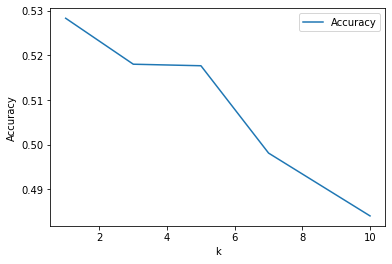

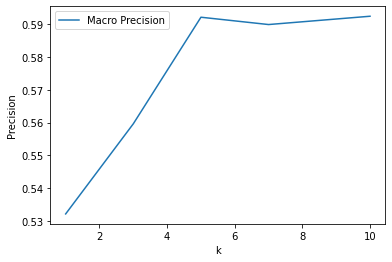

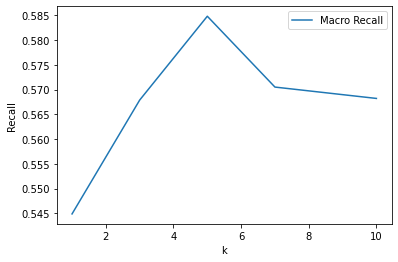

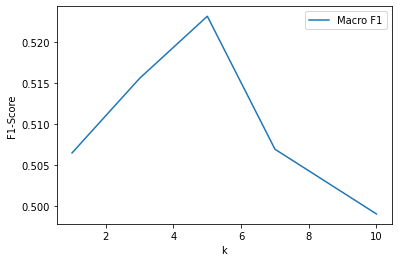

In [29]:
#calculating over the k=[1,3,5,7,10] as asked in 1st part
knn.calculateAccuracyOverK()

### Part 2

k= 1
Accuracy is: 0.5395954748028796

Confusion Matrix=
[[394  84 135]
 [143 263  65]
 [746 170 917]]
              precision    recall  f1-score   support

           0       0.31      0.64      0.42       613
           1       0.51      0.56      0.53       471
           2       0.82      0.50      0.62      1833

    accuracy                           0.54      2917
   macro avg       0.55      0.57      0.52      2917
weighted avg       0.66      0.54      0.56      2917



k= 3
Accuracy is: 0.5011998628728145

Confusion Matrix=
[[487  56  70]
 [202 229  40]
 [983 104 746]]
              precision    recall  f1-score   support

           0       0.29      0.79      0.43       613
           1       0.59      0.49      0.53       471
           2       0.87      0.41      0.55      1833

    accuracy                           0.50      2917
   macro avg       0.58      0.56      0.50      2917
weighted avg       0.70      0.50      0.52      2917



k= 5
Accuracy is: 0.4809736030

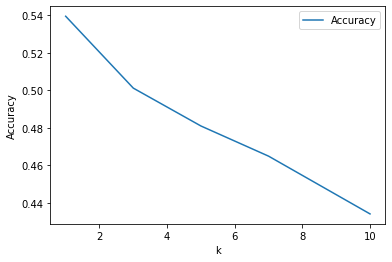

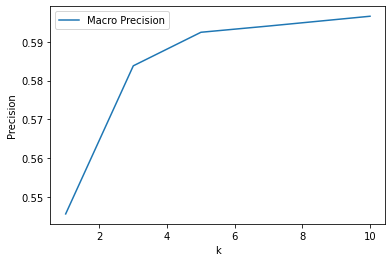

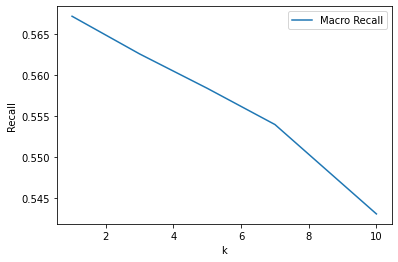

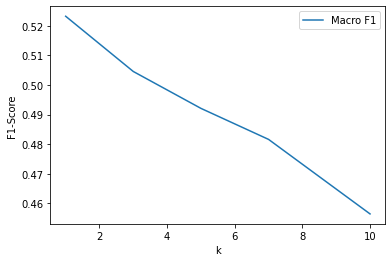

In [30]:
#function to perform the same computation as in part1 using scikit learn
knn.part2()

### Part3

In [31]:
### preparing dataset for part 3 

##Extract features function
##Function copied from TA provided snipped from the A1 PDF Link and modified that if some text is not found completely then return with 0 vector of size 300
def extract_features(text,i):
  try:
    words = [word for word in text.split() if word in word2vec.vocab]
    result = np.mean(word2vec[words], axis=0)
    
  except:
    result = np.zeros((300,))

  return result

In [32]:
#Function to convert text into embeedings 

def createTrainingTestingEmbeedings():
  trainEmbeedings = []
  testEmbeedings = []
  for i,data in enumerate(trainSet['Tweet']):
    
    emb = extract_features(data,i)
    trainEmbeedings.append(emb)
  # print("Testing data")
  for i,data in enumerate(testSet['Tweet']):
    emb = extract_features(data,i)
    testEmbeedings.append(emb)

  return trainEmbeedings,testEmbeedings



In [33]:
#getting embeedings of training and testing data
Xtrain,Xtest = createTrainingTestingEmbeedings()

Testing data


In [34]:
#Instantiating a class object with embeedings data
newKnn = KNN(Xtrain,trainLabel,Xtest,testLabel,labelDict,k=1,isDone=False)

For k= 1
Accuracy: 0.7096331847788824
Confusion Matrix: [[ 242   67  146]
 [  81  257  116]
 [ 290  147 1571]]
Conusion matrix with respect to 0 class
[[ 242.  213.]
 [ 371. 2091.]]
Conusion matrix with respect to 1 class
[[ 257.  197.]
 [ 214. 2249.]]
Conusion matrix with respect to 2 class
[[1571.  437.]
 [ 262.  647.]]
Macro Precision= 0.626772648316868
Macro Recall= 0.5991640836320428
Macro F1 Score= 0.6089584459682368


For k= 3
Accuracy: 0.7329448063078505
Confusion Matrix: [[ 208   44  106]
 [  65  264   61]
 [ 340  163 1666]]
Conusion matrix with respect to 0 class
[[ 208.  150.]
 [ 405. 2154.]]
Conusion matrix with respect to 1 class
[[ 264.  126.]
 [ 207. 2320.]]
Conusion matrix with respect to 2 class
[[1666.  503.]
 [ 167.  581.]]
Macro Precision= 0.6753415200806193
Macro Recall= 0.6029056416927999
Macro F1 Score= 0.6247494770349217


For k= 5
Accuracy: 0.7377442577991087
Confusion Matrix: [[ 156   29   63]
 [  68  262   36]
 [ 389  180 1734]]
Conusion matrix with respect t

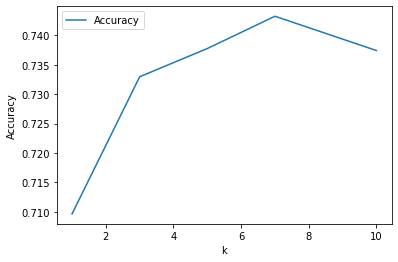

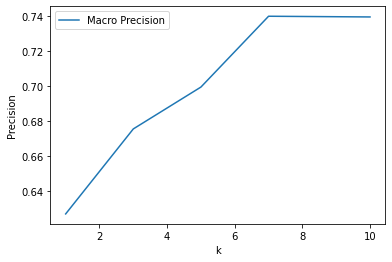

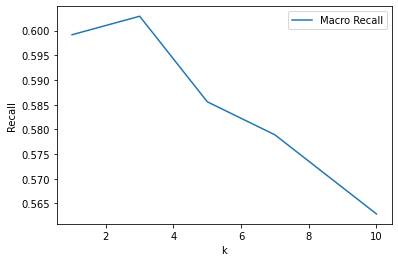

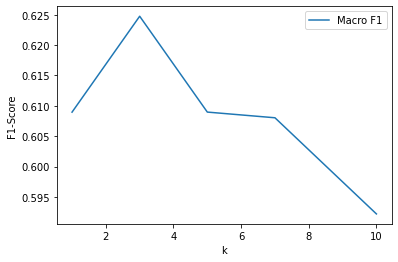

In [35]:
#Running knn on my own implementation
newKnn.calculateAccuracyOverK()

k= 1
Accuracy is: 0.7062050051422695

Confusion Matrix=
[[ 235   91  287]
 [  67  257  147]
 [ 147  118 1568]]
              precision    recall  f1-score   support

           0       0.52      0.38      0.44       613
           1       0.55      0.55      0.55       471
           2       0.78      0.86      0.82      1833

    accuracy                           0.71      2917
   macro avg       0.62      0.59      0.60      2917
weighted avg       0.69      0.71      0.70      2917



k= 3
Accuracy is: 0.7339732601988345

Confusion Matrix=
[[ 234   58  321]
 [  61  255  155]
 [ 132   49 1652]]
              precision    recall  f1-score   support

           0       0.55      0.38      0.45       613
           1       0.70      0.54      0.61       471
           2       0.78      0.90      0.83      1833

    accuracy                           0.73      2917
   macro avg       0.68      0.61      0.63      2917
weighted avg       0.72      0.73      0.72      2917



k= 5
Accurac

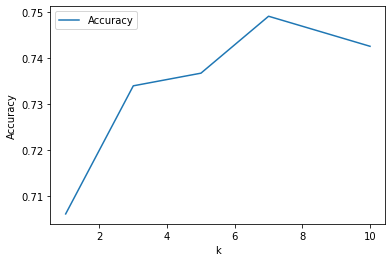

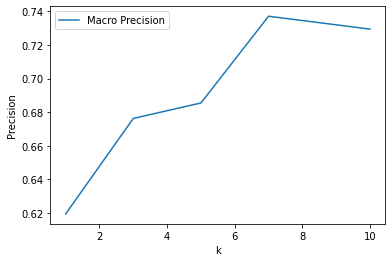

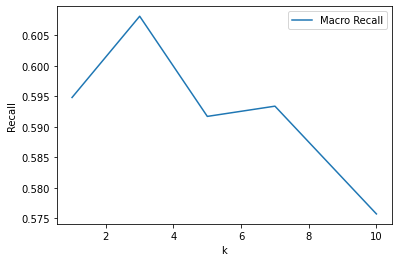

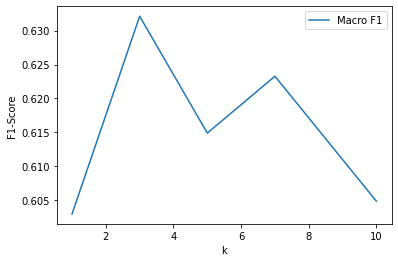

In [36]:
#Running knn on SCIKIT Learn implementation
newKnn.part2()